In [1]:
!pip install numpy
! pip install tensorflow
!pip install tqdm

Epoch 1: Loss=2.3037, Accuracy=0.3439
Epoch 2: Loss=2.2574, Accuracy=0.4083
Epoch 3: Loss=2.1190, Accuracy=0.4195
Epoch 4: Loss=1.8205, Accuracy=0.5815
Epoch 5: Loss=1.4287, Accuracy=0.6771
Epoch 6: Loss=1.1152, Accuracy=0.7393
Epoch 7: Loss=0.9113, Accuracy=0.7901
Epoch 8: Loss=0.7781, Accuracy=0.8141
Epoch 9: Loss=0.6858, Accuracy=0.8347
Epoch 10: Loss=0.6155, Accuracy=0.8489
Epoch 11: Loss=0.5657, Accuracy=0.8611
Epoch 12: Loss=0.5272, Accuracy=0.8703
Epoch 13: Loss=0.4935, Accuracy=0.8763
Epoch 14: Loss=0.4671, Accuracy=0.8810
Epoch 15: Loss=0.4467, Accuracy=0.8850
Epoch 16: Loss=0.4299, Accuracy=0.8890
Epoch 17: Loss=0.4139, Accuracy=0.8920
Epoch 18: Loss=0.4009, Accuracy=0.8941
Epoch 19: Loss=0.3885, Accuracy=0.8960
Epoch 20: Loss=0.3790, Accuracy=0.8982

Final test accuracy: 0.8650


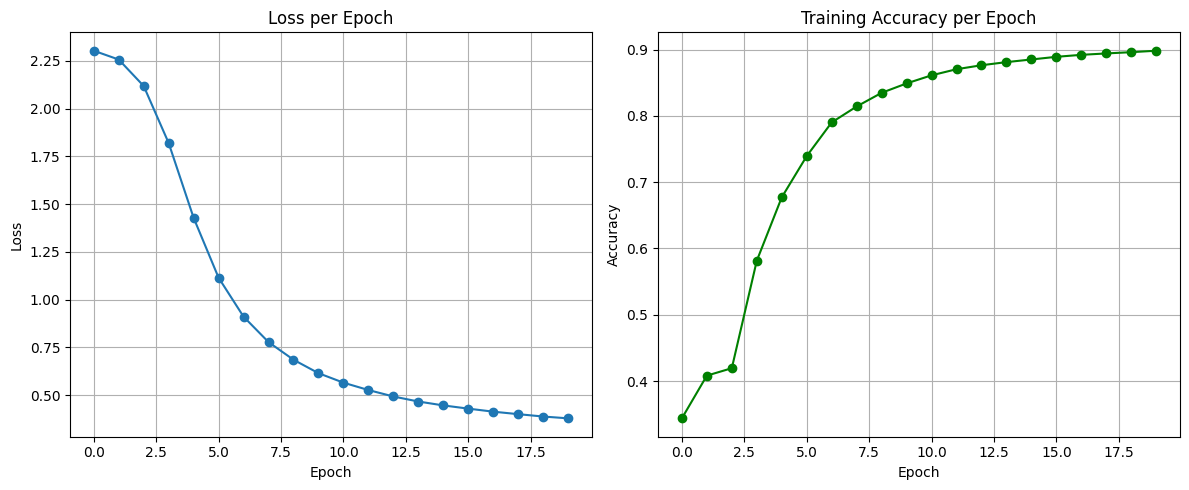

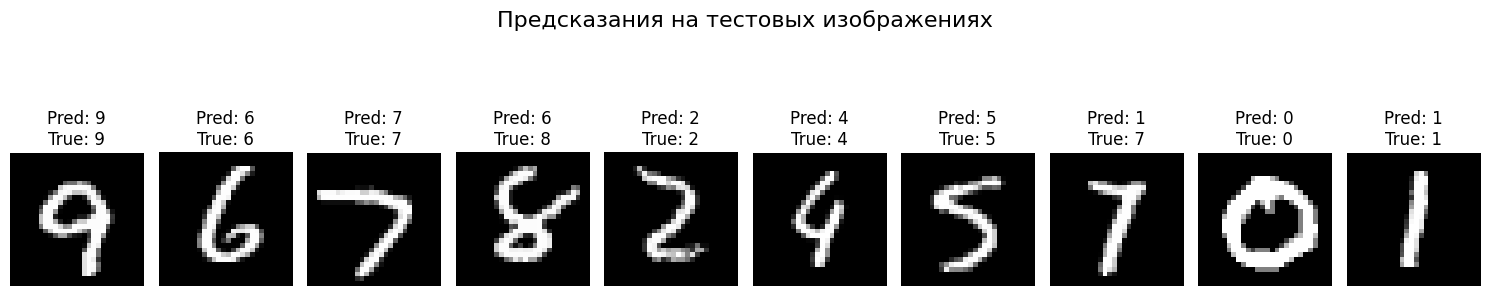

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# --- Гиперпараметры нейросети ---
input_size = 784          # Кол-во входных нейронов (28x28 пикселей)
hidden_size = 128         # Размер скрытого слоя (выбирается эмпирически)
output_size = 10          # Кол-во классов (цифры 0-9)
learning_rate = 0.01      # Скорость обучения
epochs = 20               # Количество эпох
batch_size = 64           # Размер мини-батча (ускоряет обучение)

# --- Функции активации и потерь ---
def relu(x):
    """ReLU — функция активации, заменяет отрицательные значения на 0"""
    return np.maximum(0, x)

def relu_derivative(x):
    """Производная ReLU: 1 там, где x > 0, иначе 0"""
    return (x > 0).astype(float)

def softmax(x):
    """Softmax — нормализует выходы для многоклассовой классификации"""
    exps = np.exp(x - np.max(x))  # вычитание максимума для числовой стабильности
    return exps / np.sum(exps, axis=1, keepdims=True)

def cross_entropy(y_true, y_pred):
    """Функция потерь: кросс-энтропия для one-hot меток"""
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-9), axis=1))  # 1e-9 для избежания log(0)

# --- Загрузка и нормализация данных MNIST ---
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем 28x28 в 784 и нормализуем пиксели в диапазон [0, 1]
x_train = x_train[:10000].reshape(-1, input_size) / 255.0
x_test = x_test[:2000].reshape(-1, input_size) / 255.0

# Преобразуем метки в формат one-hot для многоклассовой классификации
y_train = to_categorical(y_train[:10000], output_size)
y_test = to_categorical(y_test[:2000], output_size)

# --- Инициализация весов ---
np.random.seed(42)  # Для воспроизводимости

# Веса и смещения для скрытого слоя
W1 = np.random.randn(input_size, hidden_size) * 0.01  # Малые значения
b1 = np.zeros((1, hidden_size))

# Веса и смещения для выходного слоя
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))

# --- Логирование метрик обучения ---
loss_history = []
accuracy_history = []

# --- Обучение сети ---
for epoch in range(epochs):
    # Перемешиваем данные в начале каждой эпохи
    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    x_train_shuffled = x_train[indices]
    y_train_shuffled = y_train[indices]

    epoch_loss = 0
    correct_preds = 0

    # Обучаемся по мини-батчам
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train_shuffled[i:i + batch_size]
        y_batch = y_train_shuffled[i:i + batch_size]

        # --- Прямой проход (forward pass) ---
        z1 = np.dot(x_batch, W1) + b1         # Взвешенная сумма скрытого слоя
        a1 = relu(z1)                         # Активация скрытого слоя (ReLU)
        z2 = np.dot(a1, W2) + b2              # Взвешенная сумма выходного слоя
        a2 = softmax(z2)                      # Активация выходного слоя (Softmax)

        # --- Вычисление потерь и точности ---
        loss = cross_entropy(y_batch, a2)
        epoch_loss += loss

        predictions = np.argmax(a2, axis=1)
        targets = np.argmax(y_batch, axis=1)
        correct_preds += np.sum(predictions == targets)

        # --- Обратное распространение (backpropagation) ---
        dz2 = a2 - y_batch                          # Градиент потерь по выходу
        dW2 = np.dot(a1.T, dz2) / batch_size        # Градиент по весам выходного слоя
        db2 = np.sum(dz2, axis=0, keepdims=True) / batch_size

        dz1 = np.dot(dz2, W2.T) * relu_derivative(z1)  # Градиент по скрытому слою
        dW1 = np.dot(x_batch.T, dz1) / batch_size
        db1 = np.sum(dz1, axis=0, keepdims=True) / batch_size

        # --- Обновление весов (градиентный спуск) ---
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1

    # --- Метрики за эпоху ---
    avg_loss = epoch_loss / (len(x_train) / batch_size)
    accuracy = correct_preds / len(x_train)
    loss_history.append(avg_loss)
    accuracy_history.append(accuracy)

    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={accuracy:.4f}")

# --- Финальное тестирование модели ---
z1 = np.dot(x_test, W1) + b1
a1 = relu(z1)
z2 = np.dot(a1, W2) + b2
a2 = softmax(z2)

# Прогнозы и точность
test_preds = np.argmax(a2, axis=1)
test_labels = np.argmax(y_test, axis=1)
test_accuracy = np.mean(test_preds == test_labels)
print(f"\nFinal test accuracy: {test_accuracy:.4f}")

# --- Визуализация потерь и точности по эпохам ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, marker='o', color='green')
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()

plt.tight_layout()
plt.show()

# --- Визуализация предсказаний на 10 случайных изображениях ---
import random
indices = random.sample(range(len(x_test)), 10)

plt.figure(figsize=(15, 4))
for i, idx in enumerate(indices):
    image = x_test[idx].reshape(28, 28)
    pred = test_preds[idx]
    true = test_labels[idx]

    plt.subplot(1, 10, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Pred: {pred}\nTrue: {true}")
    plt.axis("off")

plt.suptitle("Предсказания на тестовых изображениях", fontsize=16)
plt.tight_layout()
plt.show()